# [LiteLLM Observability with Langfuse](https://langfuse.com/docs/integrations/litellm/tracing)

LiteLLM ([GitHub](https://github.com/BerriAI/litellm)): Use any LLM as a drop in replacement for GPT. Use Azure, OpenAI, Cohere, Anthropic, Ollama, VLLM, Sagemaker, HuggingFace, Replicate (100+ LLMs).

There are three ways to integrate LiteLLM with Langfuse:

1. LiteLLM Proxy with OpenAI SDK Wrapper, the proxy standardizes 100+ models on the OpenAI API schema and the Langfuse OpenAI SDK wrapper instruments the LLM calls.
2. LiteLLM Proxy which can send logs to Langfuse if enabled in the UI.
3. LiteLLM Python SDK which can send logs to Langfuse if the environment variables are set.

In [ ]:
!pip install litellm langfuse=2.60.8 --upgrade

import os
os._exit(00)

Set your Langfuse API keys and endpoint. In this sample we're just using the [simple Langfuse integration for LiteLLM](https://langfuse.com/docs/integrations/litellm/tracing), but there's also the option to use the OpenTelemetry standard for traces. More information [here](https://langfuse.com/docs/opentelemetry/get-started)

In [ ]:
import os
import litellm
import boto3

REGION = boto3.Session().region_name

LANGFUSE_SECRET_KEY=input("Enter your Langfuse Secret Key: ")
LANGFUSE_PUBLIC_KEY=input("Enter your Langfuse Public Key: ")

os.environ["LANGFUSE_SECRET_KEY"] = LANGFUSE_SECRET_KEY
os.environ["LANGFUSE_PUBLIC_KEY"] = LANGFUSE_PUBLIC_KEY
os.environ["LANGFUSE_HOST"]="https://us.cloud.langfuse.com" # US data region
#os.environ["LANGFUSE_HOST"]="https://cloud.langfuse.com" # EU data region

# Configure callbacks
litellm.success_callback = ["langfuse"]
litellm.failure_callback = ["langfuse"]

print("WE WILL USE THE API KEY IN THE OTHER NOTEBOOK")
print(f'LANGFUSE_SECRET_KEY="{LANGFUSE_SECRET_KEY}"')
print(f'LANGFUSE_PUBLIC_KEY="{LANGFUSE_PUBLIC_KEY}"')

## 1. Basic LLM invocations

We will start with a very simple completion LLM call, befire jumpin into an autonomous agent execution.

In [ ]:
input_text = "What is the weather like in Bari, Italy?"

messages = [{
        "role": "user",
        "content": input_text
}]

response = litellm.completion(
   model="bedrock/us.amazon.nova-pro-v1:0", # Uncomment to use Amazon Bedrock
   aws_region_name=REGION,
   messages=messages,
   max_tokens=4096,
   temperature=0.1,
)['choices'][0]['message']

print(response)

In [ ]:
# Adding metadata for tracing

response = litellm.completion(
   model="bedrock/us.amazon.nova-pro-v1:0", # Uncomment to use Amazon Bedrock
   aws_region_name=REGION,
   messages=messages,
   max_tokens=4096,
   temperature=0.1,
   metadata={
      "trace_user_id": "test-user-0001",             # set langfuse Trace User ID
      "session_id": "test-session-0001",             # set langfuse Session ID
      "tags": ["AWS Workshop", "Hands-on Lab"]       # set langfuse Tags
  },
)['choices'][0]['message']

print(response)

In [ ]:
# Add the LangFuse decorator
from langfuse.decorators import observe, langfuse_context

@observe(name="llm-call", as_type="generation") # Indicate this function is for generation
def invoke_llm(messages):
    response = litellm.completion(
       model="bedrock/us.amazon.nova-pro-v1:0", # Uncomment to use Amazon Bedrock
       aws_region_name=REGION,
       messages=messages,
       max_tokens=4096,
       temperature=0.1,
       metadata={
           "existing_trace_id": langfuse_context.get_current_trace_id(),   # set langfuse trace ID
           "parent_observation_id": langfuse_context.get_current_observation_id(),
       },
    )['choices'][0]['message']
    return response

@observe(name="prompting")
def prompt(input_text):
    return [{
        "role": "user",
        "content": input_text
    }]

@observe()
def ask_weather(question):
    messages = prompt(question)
    response = invoke_llm(messages)
    return response
    
ask_weather("What is the weather like in San Francisco?")

**Now go to the project you've just created in Langfuse cloud, and you should be able to see a single trace got created:**

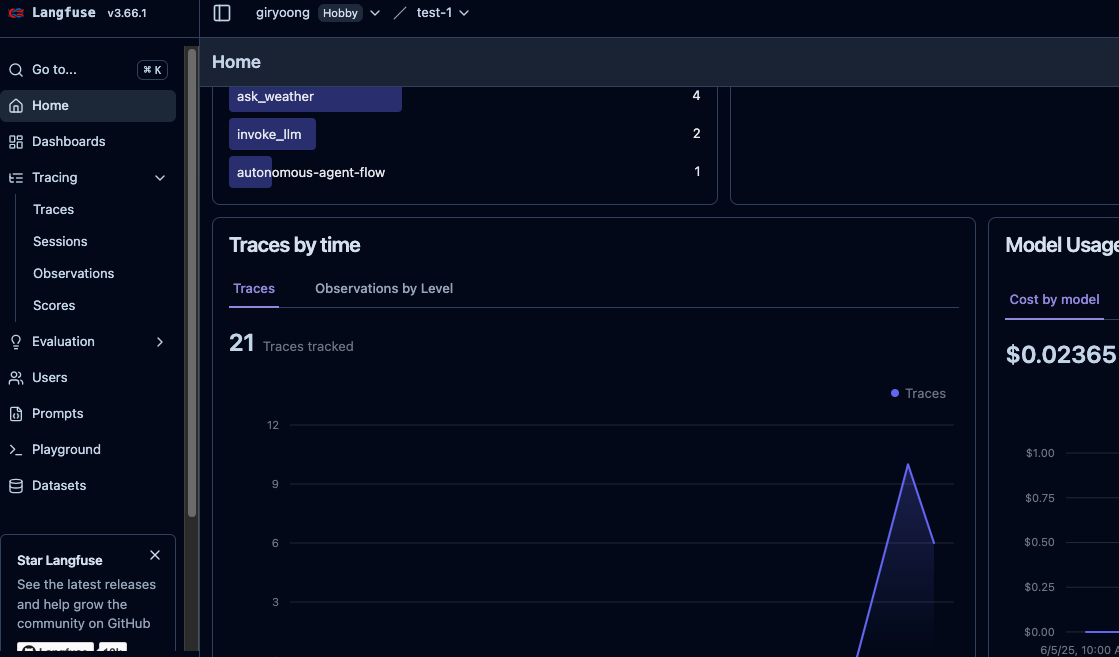

**Navigate various functions in the menu and find out how each invocation was tagged for tracing.**

## 2. Agentic flows
Let's try something more complicated:

In [ ]:
# Tools definitions for an Agent

from langfuse.decorators import observe, langfuse_context
import json


@observe(as_type="search")
def get_weather(city: str, country: str = "US") -> dict:
    """Get the current weather for a city."""
    # This is a mock implementation
    # Add API call to get real weather information.
    return {
        "city": city,
        "country": country,
        "temperature": 72,
        "conditions": "sunny"
    }


@observe(as_type="generation")
def translate_text(text: str, target_language: str) -> dict:
    """Translate text to the target language."""
    # This is a mock implementation
    # Invoke an LLM here for real implementation.
    return {
        "original": text,
        "translated": f"[{text} translated to {target_language}]",
        "target_language": target_language
    }

# Define the tools
tools = [
    # Weather tool
    ({
        "type": "function",
        "function": {
            "name": "get_weather",
            "description": "Get the current weather for a city",
            "parameters": {
                "type": "object",
                "properties": {
                    "city": {
                        "type": "string",
                        "description": "The name of the city"
                    },
                    "country": {
                        "type": "string",
                        "description": "The country code (default: US)",
                        "default": "US"
                    }
                },
                "required": ["city"]
            }
        }
    }, get_weather),
    
    # Translation tool
    ({
        "type": "function",
        "function": {
            "name": "translate_text",
            "description": "Translate text to another language",
            "parameters": {
                "type": "object",
                "properties": {
                    "text": {
                        "type": "string",
                        "description": "The text to translate"
                    },
                    "target_language": {
                        "type": "string",
                        "description": "The target language code (e.g., 'es' for Spanish)"
                    }
                },
                "required": ["text", "target_language"]
            }
        }
    }, translate_text)
]

In [ ]:
# Agent definition

import json
import litellm
import uuid
from langfuse.decorators import observe, langfuse_context


class AutonomousAgent:
    def __init__(self, tools:list, model_id:str="bedrock/us.amazon.nova-pro-v1:0", max_tokens:int=5*1024, temperature:float=0.1):
        self.model_id = model_id
        self.max_tokens = max_tokens
        self.temperature = temperature
        self.tools = tools
        self.messages = []

    @observe(name="agent-thinking")
    def think(self):
        response = litellm.completion(
            messages=self.messages,
            aws_region_name=REGION,
            model=self.model_id,
            max_tokens=self.max_tokens,
            temperature=self.temperature,
            tools=[x[0] for x in tools],
            metadata={
               "name": "agent",
               "existing_trace_id": langfuse_context.get_current_trace_id(),   # set langfuse trace ID
               "parent_observation_id": langfuse_context.get_current_observation_id(),
            }
        )['choices'][0]['message']
        return response
    
    @observe(name="autonomous-agent-flow")
    def converse(self, input_text:str):
        self.messages = [{
            "role": "user",
            "content": input_text
        }]
        print(f"{self.messages[-1]['role']}: {self.messages[-1]['content'].strip()}")

        response = self.think()
        
        self.messages.append(dict(response))
        print(f"{self.messages[-1]['role']}: {self.messages[-1]['content'].strip()}")

        # Loop until no more tool calls
        tool_call = True
        while tool_call is not None:
            tool_call = response.get('tool_calls', None)
            required_tool_name = tool_call[0].function.name
            required_tool_arguments = json.loads(tool_call[0].function.arguments)
            for tool_definition, tool_function in tools:
                if tool_definition['function']['name'] == required_tool_name:
                    tool_response = tool_function(**required_tool_arguments)
                    break
            self.messages.append({
                "tool_call_id": tool_call[0]['id'],
                "role": "tool",
                "name": required_tool_name,
                "content": json.dumps(tool_response)
            })
            response = self.think()
            self.messages.append(dict(response))
            print(f"{self.messages[-1]['role']}: {self.messages[-1]['content'].strip()}")

            tool_call = response.get('tool_calls', None)


In [ ]:
# Let the agent work

agent = AutonomousAgent(tools)
agent.converse("What is the weather in Bari, Italy? Give me the answer in Italian")

In this example, we run an autonomous agents that has two (simulated) tools assigned to it. In the code, we assign every `completion` API call to the same Langfuse Trace ID. After that, we can see in Langfuse UI the total cost of the agent invocation, the total latency, as well as a timeline breakdown of the API calls that happened behind the scenes.

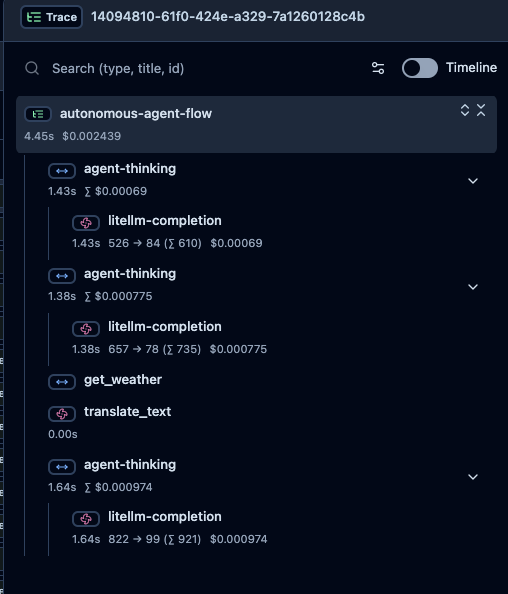